# Advanced Metrics

As a pre-requisite for this notebook, completing the casesExample notebook is highly recommended, although if you have a good grasp of how to evaluate Metrics already, then feel free to continue.

In this notebook, we'll see how the C3 Metrics system can be extended on the fly to include new metrics defined in terms of the old. We'll also explore how options such as `interval` and aggregation functions such as `AVG` and `MIN` change the output.

This notebook can be run on any tag containing an image of the Covid-19 Datalake.

We've developed this notebook to be more accessible to DTI researchers so they can learn about Metrics without having to learn details surrounding provisioning and data integration. This should give you an accurate flavor of the capabilities of C3 Metrics which you can immediately apply to your own datasets once you master the provisioning and data integration aspects of C3.

## Setup

Here, we load modules, and if necessary, establish a connection to a running C3 session.

In [92]:
import pandas as pd
import re
import dateutil
import matplotlib.pyplot as plt

In [ ]:
try:
    # Check whether the c3 object is defined
    c3
except NameError:
    # Connect to a c3 cluster and create the c3 object
    from c3python import get_c3
    c3 = get_c3('<vanity_url>', '<tenant>', '<tag>')

In [2]:
try:
    c3
except NameError:
    from c3python import get_c3
    c3 = get_c3('https://dti-mkrafczyk.c3dti.ai', 'dti', 'mkrafczyk')

Username: mkrafcz2@illinois.edu
Password: ········


## Simple vs Compound Metrics

Generally, Metrics in C3 fall into two categories. The `SimpleMetrics` and the `CompoundMetrics`. Generally, Simple Metrics tell the C3 system how to evaluate a given metric on a given Type. So, for a specific SimpleMetric, information defining a source type, a 'path' showing how to navigate to the data inside the type, and an expression defining what the metric is.

Compound Metrics are an easy way for the C3 system to create new metrics in terms of already existing metrics. Perhaps perversely, they're easier to use than SimpleMetrics. This is because you don't have to define a specific source type for a given Compound Metric. At evaluation time, C3 checks whether all required SimpleMetrics (as part of the Compound Metric) are available, and fails with an error if any are missing.

While normally, `SimpleMetric`s and `CompoundMetric`s are defined as part of a C3 package you provision, new metrics can also be defined on the fly. Once defined, you can use the `evalMetricsWithMetadata` method to evaluate such metrics.

## Check what's already defined

The C3 type `MetricEvaluatable` defines the C3 Metrics framework. Usefully, it includes the function `listMetrics`. Let's have a look at that now on the OutbreakLocation type.


In [36]:
outbreaklocation_metrics = pd.DataFrame(c3.OutbreakLocation.listMetrics().toJson())
outbreaklocation_metrics

,type,name,expression,meta,id,version,srcType,path,tsDecl,unit,cache
0,SimpleMetric,ARITreatment_PercentUnder5,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ARITreatment_PercentUnder5_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.STA....,NaN,NaN,NaN
1,SimpleMetric,ATMs,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ATMs_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'FB.ATM....,NaN,NaN,NaN
2,SimpleMetric,AgeDependencyRatio,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
3,SimpleMetric,AgeDependencyRatio_Old,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_Old_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
4,SimpleMetric,AgeDependencyRatio_Young,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_Young_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2754,SimpleMetric,WomenMarriedby15,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WomenMarriedby15_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.M15....,NaN,NaN,NaN
2755,SimpleMetric,WomenMarriedby18,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WomenMarriedby18_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.M18....,NaN,NaN,NaN
2756,SimpleMetric,newHIVInfection,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",newHIVInfection_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.HIV....,NaN,NaN,NaN
2757,SimpleMetric,newHIVInfections_0_14,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",newHIVInfections_0_14_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.HIV....,NaN,NaN,NaN


At the time of writing this notebook, there are ~2800 metrics, wow that's a lot! Let's evaluate a few. We focus on a couple interesting metrics here, but of course feel free to explore the above list yourself and try a few yourself.

Let's have a look at `Realtor_AverageListingPrice`, `JHU_ConfirmedCases`, and `CDS_ICU`. (We'll discuss later why we chose these. Feel free to explore yourself though)

## Let's plot them first

In [138]:
ids = ['Champaign_Illinois_UnitedStates',
       'Cook_Illinois_UnitedStates',
       'ContraCosta_California_UnitedStates',
       'Alameda_California_UnitedStates']
expressions = ['Realtor_AverageListingPrice',
               'JHU_ConfirmedCases',
               'JHU_ConfirmedDeaths',
               'OIET_LowIncEarningsSmallBusinesses_Pay']
res = c3.OutbreakLocation.evalMetrics(spec={
    'ids': ids,
    'expressions': expressions,
    'start': '2020-01-01',
    'end': '2020-08-01',
    'interval': 'DAY'
})

In [139]:
res_df = c3.Dataset.toPandas(dataset=c3.Dataset.fromEvalMetricsResult(result=res))

In [140]:
res_df

,JHU_ConfirmedCases,JHU_ConfirmedDeaths,OIET_LowIncEarningsSmallBusinesses_Pay,Realtor_AverageListingPrice
Alameda_California_UnitedStates_2020-01-01T00:00:00,0.0,0.0,0.000,1309312.0
Alameda_California_UnitedStates_2020-01-02T00:00:00,0.0,0.0,0.000,1309312.0
Alameda_California_UnitedStates_2020-01-03T00:00:00,0.0,0.0,0.000,1309312.0
Alameda_California_UnitedStates_2020-01-04T00:00:00,0.0,0.0,0.000,1309312.0
Alameda_California_UnitedStates_2020-01-05T00:00:00,0.0,0.0,0.000,1309312.0
...,...,...,...,...
Cook_Illinois_UnitedStates_2020-07-27T00:00:00,103008.0,4842.0,-0.406,508096.0
Cook_Illinois_UnitedStates_2020-07-28T00:00:00,103441.0,4857.0,-0.406,508096.0
Cook_Illinois_UnitedStates_2020-07-29T00:00:00,104001.0,4864.0,-0.406,508096.0
Cook_Illinois_UnitedStates_2020-07-30T00:00:00,104687.0,4872.0,-0.406,508096.0


Okay, that dataframe isn't very easy to work with, let's create a processing function to help out.

In [141]:
def parse_df(in_df):
    '''
    Takes a dataframe which is a result of an evalMetrics call. The dataframe
    you you pass through 'in_df' can be created like this:
    
    res = c3.<Type>.evalMetrics(<evalSpec>)
    ds = c3.Dataset.fromEvalMetricsResult(result=res)
    in_df = c3.Dataset.toPandas(dataset=ds)
    
    This function takes an index of the form "<Id>_<ISODate>" and breaks it
    into two columns 'id' and 'date'
    
    Arguments:
        in_df: Input dataframe. It should have an index of the form "<Id>_<ISODate>"
            and have columns which correspond to the expressions evaluated in the
            evalMetrics call.
    
    Return Value:
        A Pandas DataFrame with id/date multi-index.
    '''
    # A regular expression to split the index into component columns
    index_splitter = re.compile('^(.*)_([^_]*)$')
    # A function to take an idx string and split it into its component columns.
    def split_index(s):
        match = index_splitter.match(s.name)
        if match is None:
            return [None, s.name]
        else:
            return [match.group(1), dateutil.parser.isoparse(match.group(2))]
    # First apply the split_index function along the rows of the dataframe.
    # expand the result.
    new_idx = in_df.apply(split_index, axis=1, result_type='expand')
    # Rename columns in the result to make them more understandable
    new_idx = new_idx.rename(columns={0: 'id', 1:'date'})
    # Add the new columns to the original dataframe
    df = pd.concat([new_idx, in_df], axis=1)
    # Finally change the index to a multi-index of two levels, 'id' and 'date'
    df = df.set_index(['id', 'date'])
    return df

df = parse_df(res_df)

In [142]:
def plot_expression(df, expression, ids=[]):
    """
    Make some nice plots of a given expression from a dataframe containing the
    results of an evalMetrics call.
    """
    
    _, ax = plt.subplots(1, figsize=(15,10))
    if ids == []:
        ids = df.index.levels[0]
    for Id in ids:
        idf = df.loc[Id]
        idf.plot(ax=ax, y=expression, label=Id)
    ax.set_ylabel(expression)
    ax.set_ylim(bottom=0)
    ax.grid(True)
    return ax

<AxesSubplot:xlabel='date', ylabel='JHU_ConfirmedCases'>

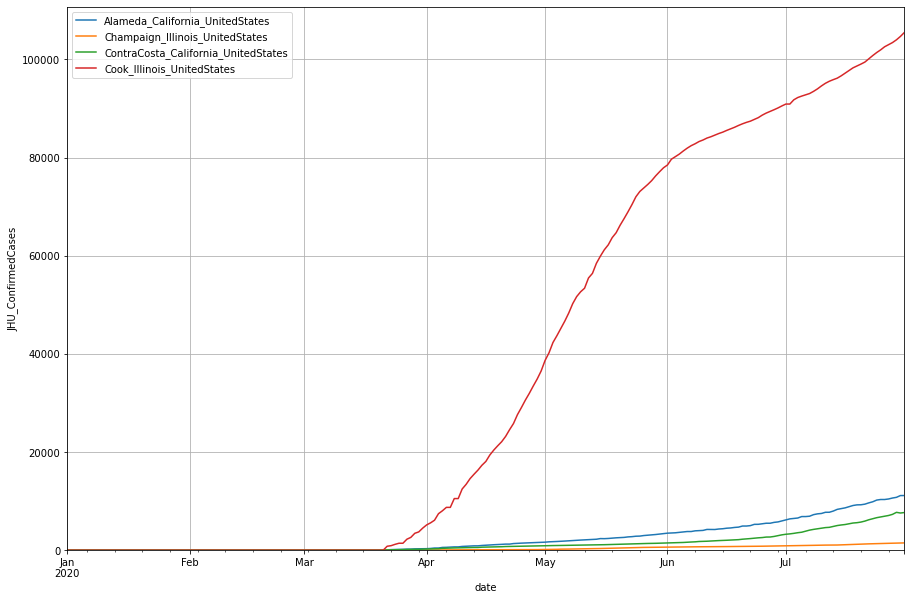

In [143]:
plot_expression(df, 'JHU_ConfirmedCases')

<AxesSubplot:xlabel='date', ylabel='JHU_ConfirmedDeaths'>

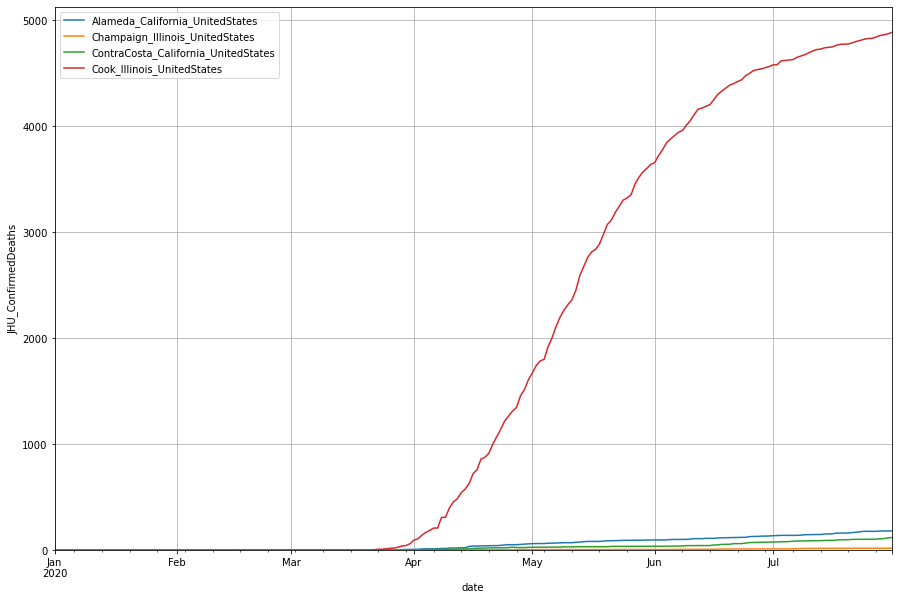

In [144]:
plot_expression(df, 'JHU_ConfirmedDeaths')

<AxesSubplot:xlabel='date', ylabel='Realtor_AverageListingPrice'>

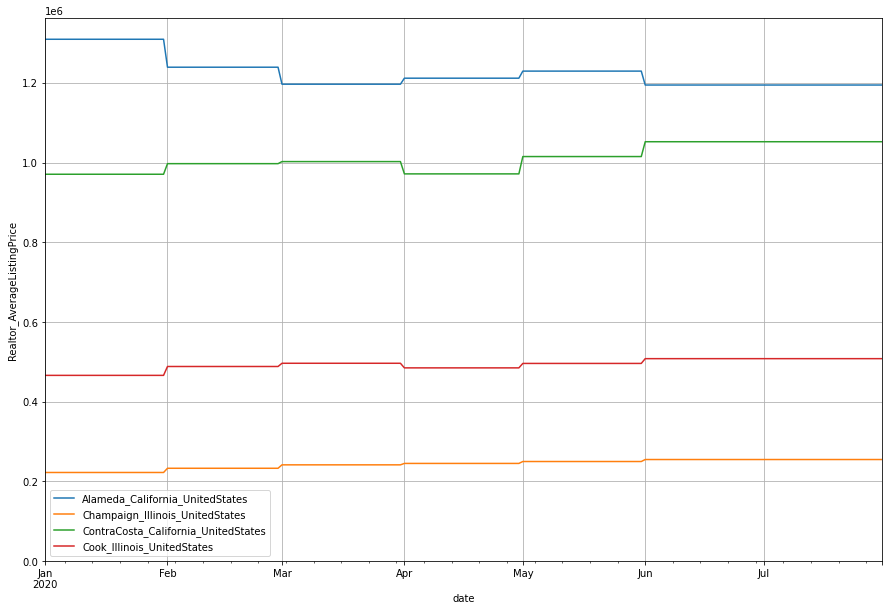

In [145]:
plot_expression(df, 'Realtor_AverageListingPrice')

<AxesSubplot:xlabel='date', ylabel='OIET_LowIncEarningsSmallBusinesses_Pay'>

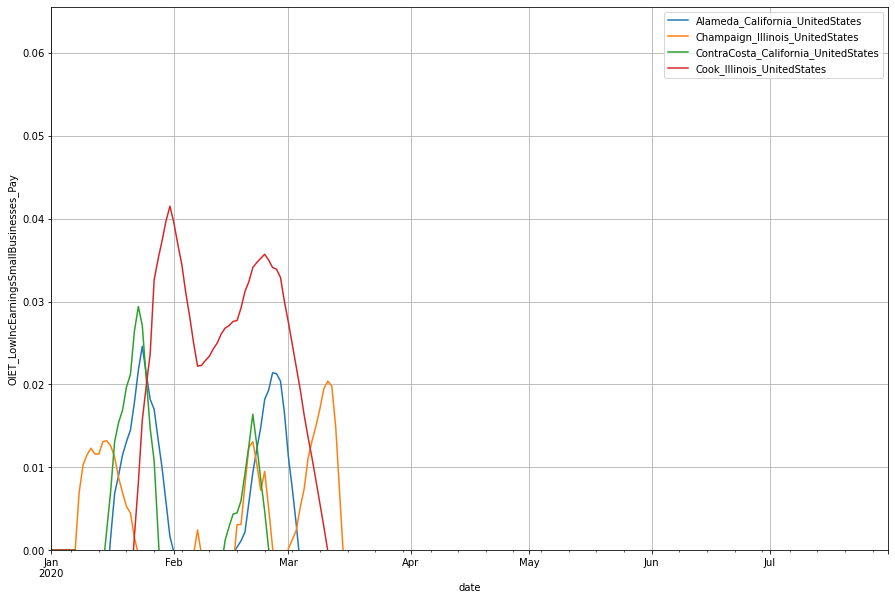

In [146]:
plot_expression(df, 'OIET_LowIncEarningsSmallBusinesses_Pay')

In [131]:

c3.Po

,type,name,expression,meta,id,version,srcType,path,tsDecl,unit,cache
0,SimpleMetric,ARITreatment_PercentUnder5,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ARITreatment_PercentUnder5_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.STA....,NaN,NaN,NaN
1,SimpleMetric,ATMs,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",ATMs_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'FB.ATM....,NaN,NaN,NaN
2,SimpleMetric,AgeDependencyRatio,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
3,SimpleMetric,AgeDependencyRatio_Old,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_Old_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
4,SimpleMetric,AgeDependencyRatio_Young,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",AgeDependencyRatio_Young_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.POP....,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2754,SimpleMetric,WomenMarriedby15,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WomenMarriedby15_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.M15....,NaN,NaN,NaN
2755,SimpleMetric,WomenMarriedby18,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",WomenMarriedby18_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SP.M18....,NaN,NaN,NaN
2756,SimpleMetric,newHIVInfection,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",newHIVInfection_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.HIV....,NaN,NaN,NaN
2757,SimpleMetric,newHIVInfections_0_14,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",newHIVInfections_0_14_OutbreakLocation,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SH.HIV....,NaN,NaN,NaN


In [127]:
print(c3.SimpleMetric.get('CDS_ICU_OutbreakLocation'))

c3.SimpleMetric(
 name='CDS_ICU',
 expression="interpolate(sum(sum(normalized.data.quantity)), 'PREVIOUS', "
             "'MISSING')",
 meta=c3.Meta(
        tenantTagId=9,
        tenant='dti',
        tag='mkrafczyk',
        created=datetime.datetime(2020, 7, 22, 0, 2, 25, tzinfo=datetime.timezone.utc),
        createdBy='provisioner',
        updated=datetime.datetime(2020, 7, 22, 0, 2, 25, tzinfo=datetime.timezone.utc),
        updatedBy='provisioner',
        timestamp=datetime.datetime(2020, 7, 22, 0, 2, 25, tzinfo=datetime.timezone.utc),
        fetchInclude='[]',
        fetchType='SimpleMetric'),
 id='CDS_ICU_OutbreakLocation',
 version=1,
 srcType=c3.TypeRef(typeName='OutbreakLocation'),
 path="pointMeasurements.(measurementType == 'ICU' && origin == 'Corona Data "
       "Scraper')")


In [133]:
location_id = "Champaign_Illinois_UnitedStates"
res = c3.PointPhysicalMeasurementSeries.fetch({'filter': 'contains(asset,"{}")'.format(location_id)})
for obj in res.objs:
    print("{}: {}".format(obj.origin, obj.measurementType))

Realtor.com: active listing count
Realtor.com: active listing count month-over-month
Realtor.com: active listing count year-over-year
Opportunity Insight Economic Tracker: AllBusinessesEmp
Opportunity Insight Economic Tracker: AllBusinessesEmp31To33
Opportunity Insight Economic Tracker: AllBusinessesEmp44To45
Opportunity Insight Economic Tracker: AllBusinessesEmp48To49
Opportunity Insight Economic Tracker: AllBusinessesEmp62
Opportunity Insight Economic Tracker: AllBusinessesEmp72
Opportunity Insight Economic Tracker: AllBusinessesEmpInchigh
Opportunity Insight Economic Tracker: AllBusinessesEmpInclow
Opportunity Insight Economic Tracker: AllBusinessesEmpIncmiddle
Opportunity Insight Economic Tracker: AllBusinessesPay
Opportunity Insight Economic Tracker: AllBusinessesPay31To33
Opportunity Insight Economic Tracker: AllBusinessesPay44To45
Opportunity Insight Economic Tracker: AllBusinessesPay48To49
Opportunity Insight Economic Tracker: AllBusinessesPay62
Opportunity Insight Economic Tra

In [137]:
df = pd.DataFrame(c3.OutbreakLocation.listMetrics().toJson())
df = df[df.path.notna()]
df[df.path.apply(lambda s: True if 'SmallBusinessesPay' in s else False)]

,type,name,expression,meta,id,version,srcType,path,tsDecl,unit,cache
2368,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_Pay,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_Pay_Outbrea...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2369,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_Pay31To33,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_Pay31To33_O...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2370,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_Pay44To45,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_Pay44To45_O...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2371,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_Pay48To49,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_Pay48To49_O...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2372,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_Pay62,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_Pay62_Outbr...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2373,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_Pay72,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_Pay72_Outbr...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2374,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_PayInchigh,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_PayInchigh_...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2375,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_PayInclow,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_PayInclow_O...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN
2376,SimpleMetric,OIET_LowIncEarningsSmallBusinesses_PayIncmiddle,interpolate(sum(sum(normalized.data.quantity))...,"{'type': 'Meta', 'tenantTagId': 7, 'tenant': '...",OIET_LowIncEarningsSmallBusinesses_PayIncmiddl...,1,"{'type': 'TypeRef', 'typeName': 'OutbreakLocat...",pointMeasurements.(measurementType == 'SmallBu...,NaN,NaN,NaN


In [130]:
c3.PointPhysicalMeasurementSeries.fetch({'filter': 'contains(asset,"UnitedStates") && measurementType == "ICU" && origin == "Corona Data Scraper"'})

c3.FetchResult<PointPhysicalMeasurementSeries>(
 objs=c3.Arry<PointPhysicalMeasurementSeries>([c3.PointPhysicalMeasurementSeries(
         typeIdent='MS:BPMS:PPMS',
         id='SanDiego_California_UnitedStates_CoronaDataScraper_County_icu',
         name='San Diego County, California, United States',
         meta=c3.Meta(
                tenantTagId=7,
                tenant='covid',
                tag='dev',
                created=datetime.datetime(2020, 7, 17, 22, 37, 26, tzinfo=datetime.timezone.utc),
                createdBy='dataloader',
                updated=datetime.datetime(2020, 7, 17, 22, 40, 57, tzinfo=datetime.timezone.utc),
                updatedBy='dataloader',
                timestamp=datetime.datetime(2020, 7, 17, 22, 44, 10, tzinfo=datetime.timezone.utc),
                sourceFile='2020-07-06',
                fetchInclude='[]',
                fetchType='PointPhysicalMeasurementSeries'),
         version=4,
         measurementType='ICU',
         origin='Co

In [31]:
c3.AggregateOutbreakLocationMeasurementSeries.fetch({'filter': 'measurementType == "Realtor_AverageListingPrice" && origin == "Realtor.com"'})

c3.FetchResult<AggregateOutbreakLocationMeasurementSeries>(
 count=0,
 hasMore=False)

In [25]:
help(c3.AggregateOutbreakLocationMeasurementSeries)

In [8]:
newHIVInfectionMetric = c3.SimpleMetric.get('newHIVInfection_OutbreakLocation')

In [9]:
help(c3.ExpressionEngineFunction)

In [10]:
newHIVInfectionMetric.expression

"interpolate(sum(sum(normalized.data.quantity)), 'PREVIOUS', 'MISSING')"

In [11]:
newHIVInfectionMetric.path

"pointMeasurements.(measurementType == 'SH.HIV.INCD.TL' && origin == 'World Bank')"

In [14]:
c3.PointPhysicalMeasurementSeries.fetch({'filter': 'measurementType == "SH.HIV.INCD.TL" && origin == "World Bank" && exists(earliest)'})

c3.FetchResult<PointPhysicalMeasurementSeries>(count=0, hasMore=False)

In [12]:
countPointsMetric = c3.SimpleMetric(name='newHIVInfectionCount',
                                    expression='',
                                    srcType='OutbreakLocation',
                                    path=newHIVInfectionMetric.path)

In [33]:
help(c3.PointPhysicalMeasurementSeries)

In [ ]:
countMetric = c3.SimpleMetric(name='HIVCount',
                              expression='sum(count(data.quantity))',
                              srcType='OutbreakLocation',
                              path=newHIVInfectionMetric.path)

In [36]:
help(c3.OutbreakLocation)

In [34]:
print(c3.OutbreakLocation.fetch({'filter': 'id == "Champaign_Illinois_UnitedStates"',
                                 'include': 'pointMeasurements'}))

c3.FetchResult<OutbreakLocation>(
 objs=c3.Arry<OutbreakLocation>([c3.OutbreakLocation(
         typeIdent='EP_LOC',
         id='Champaign_Illinois_UnitedStates',
         meta=c3.Meta(
                fetchInclude='[{pointMeasurements:[id]},id,version,typeIdent]',
                fetchType='OutbreakLocation'),
         version=5505036,
         pointMeasurements=c3.Arry<PointPhysicalMeasurementSeries>([c3.PointPhysicalMeasurementSeries(
                              typeIdent='MS:BPMS:PPMS',
                              id='Champaign_Illinois_UnitedStates_ActiveListingCount',
                              meta=c3.Meta(
                                     fetchInclude='[id,asset,version,typeIdent]',
                                     fetchType='PointPhysicalMeasurementSeries'),
                              version=1,
                              asset=c3.PhysicalAsset(
                                      id='Champaign_Illinois_UnitedStates')),
                             c3.P

In [35]:
c3.OutbreakLocation.fetch()

c3.FetchResult<OutbreakLocation>(
 objs=c3.Arry<OutbreakLocation>([c3.OutbreakLocation(
         typeIdent='EP_LOC',
         id='-_AndhraPradesh_India',
         name='-',
         meta=c3.Meta(
                tenantTagId=7,
                tenant='covid',
                tag='dev',
                created=datetime.datetime(2020, 7, 18, 0, 1, tzinfo=datetime.timezone.utc),
                createdBy='dataloader',
                updated=datetime.datetime(2020, 7, 18, 0, 1, tzinfo=datetime.timezone.utc),
                updatedBy='dataloader',
                timestamp=datetime.datetime(2020, 7, 20, 7, 54, 41, tzinfo=datetime.timezone.utc),
                sourceFile='CanonicalIndianLineListRecordHistoric.csv',
                fetchInclude='[]',
                fetchType='OutbreakLocation'),
         version=65537,
         location=c3.PhysicalAssetLocation(
                    timestamp=datetime.datetime(2020, 4, 5, 0, 0, tzinfo=datetime.timezone.utc),
                    value=c3.Loc